# Random Forest Classifier

In [111]:
import pandas as pd
import numpy as np

freq = 'Daily'
stock = 'AAPL'
price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
y = price.direction.shift(-1).values[:-1]
predictors = pd.read_csv('../predictors/Tech/'+freq+'/'+stock+'.csv',index_col='Date')
predictors.fillna(0,inplace=True)
X = predictors.values[:-1,]
y.shape


(2536,)

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn
print(sklearn.__version__)
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

1.2.2


In [113]:
from matplotlib import pyplot as plt

In [115]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=False)
sm = SMOTE(sampling_strategy='minority',random_state=42,k_neighbors=4)
X_res,y_res = sm.fit_resample(X_train,y_train)
pipe = make_pipeline(MinMaxScaler(),RandomForestClassifier(criterion='entropy',max_depth = 100,max_features = 'sqrt',class_weight='balanced_subsample'))
pipe.fit(X_res,y_res)
y_pred = pipe.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.48      0.81      0.60       354
         1.0       0.59      0.24      0.34       407

    accuracy                           0.50       761
   macro avg       0.53      0.52      0.47       761
weighted avg       0.54      0.50      0.46       761



In [121]:
model = XGBClassifier(base_score=0.5, booster='gbtree',objective='binary:logistic', learning_rate=0.1, max_depth=5,n_estimators=1000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.20      0.29       354
         1.0       0.54      0.82      0.65       407

    accuracy                           0.53       761
   macro avg       0.52      0.51      0.47       761
weighted avg       0.52      0.53      0.48       761



[0.10101223 0.10514136 0.10200109 0.10823295 0.08962518 0.10146812
 0.09649287 0.0991365  0.10458429 0.09230542]


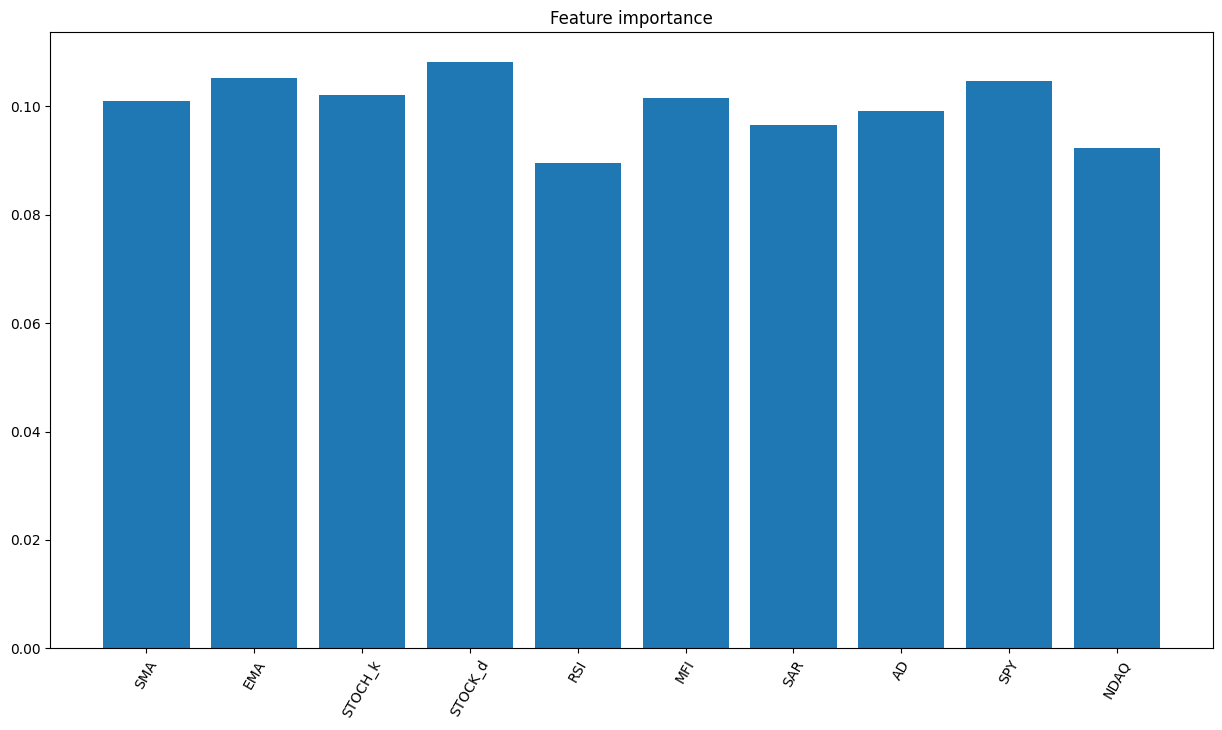

In [122]:
print(model.feature_importances_)
plt.figure(figsize=(15,8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title('Feature importance')
plt.xticks(range(len(model.feature_importances_)),predictors.columns,rotation=60)
plt.show()

In [98]:
important_features = predictors.columns[np.where(model.feature_importances_>0.02)]

In [124]:
X_se = predictors[important_features].values[:-1,]
print(X_se.shape)
X_train,X_test,y_train,y_test = train_test_split(X_se,y,test_size=0.3,shuffle=False)
sm = SMOTE(sampling_strategy='minority',random_state=42,k_neighbors=5)
X_res,y_res = sm.fit_resample(X_train,y_train)
model = XGBClassifier(base_score=0.5, booster='gbtree',objective='binary:logistic', learning_rate=0.1, max_depth=150,n_estimators=500)
model.fit(X_res,y_res)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

(2536, 10)
              precision    recall  f1-score   support

         0.0       0.51      0.40      0.45       354
         1.0       0.56      0.67      0.61       407

    accuracy                           0.55       761
   macro avg       0.54      0.54      0.53       761
weighted avg       0.54      0.55      0.54       761



In [119]:
pipe = make_pipeline(StandardScaler(),RandomForestClassifier(criterion='log_loss'))
pipe.fit(X_res,y_res)
y_pred = pipe.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.44      0.50      0.47       354
         1.0       0.51      0.45      0.48       407

    accuracy                           0.47       761
   macro avg       0.47      0.47      0.47       761
weighted avg       0.48      0.47      0.47       761

